In [1]:
import os

# Change where the jupyter notebook is running to acces custom packages
os.chdir('../')
print(os.getcwd())  

d:\AA_Licenta\DeepFake-detection


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.transforms import InterpolationMode
from helpers import evaluation, plotting, training
from helpers.CustomDataset import CustomDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [13]:
# PARAMS

BATCH_SIZE = 64
NUM_EPOCHS = 15
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
RANDOM_SEED = 2002

print(f"Device = {DEVICE}")

Device = cuda:0


In [4]:
# TRANSFORMS

train_transforms = transforms.Compose([
    transforms.Resize(
        (256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]), 
])

test_transforms = transforms.Compose([
    transforms.Resize(
        (256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

In [5]:
# PATHS TO DATA
TRAIN_PATH_DATA = 'data/train/'
TRAIN_PATH_CSV = 'data/train_labels.csv'
TEST_PATH_DATA = 'data/test/'
TEST_PATH_CSV = 'data/test_labels.csv'
VALID_PATH_DATA = 'data/validation/'
VALID_PATH_CSV = 'data/validation_labels.csv'

In [6]:
# Datasets

train_dataset = CustomDataset(
    TRAIN_PATH_CSV, TRAIN_PATH_DATA, train_transforms)
test_dataset = CustomDataset(
    TEST_PATH_CSV, TEST_PATH_DATA, test_transforms)
validation_dataset = CustomDataset(
    VALID_PATH_CSV, VALID_PATH_DATA, test_transforms)

In [7]:
# Dataloaders

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=True)

for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])
Class labels of 10 examples: tensor([1, 1, 1, 0, 0, 0, 1, 1, 0, 1])


In [12]:
model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)


# transform multiclass model into binary classifier

dropout = 0.4 # as per the pytorch implementation
in_features = 1280 # as per multiple sources
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),
    nn.Linear(in_features, 2),
)

In [15]:
#hyperparameters

loss = nn.BCELoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model = model.to(DEVICE)
device = next(model.parameters()).device
print(f"Model is on {device}")

Model is on cuda:0


In [16]:
torch.cuda.empty_cache()

Epoch: 001/015 | Batch 0000/0310 | Loss: 0.6428
Epoch: 001/015 | Batch 0100/0310 | Loss: 0.1988
Epoch: 001/015 | Batch 0200/0310 | Loss: 0.0938
Epoch: 001/015 | Batch 0300/0310 | Loss: 0.1697
Epoch: 001/015 | Train: 96.65% | Validation: 86.75%
Time elapsed: 24.30 min
Epoch: 002/015 | Batch 0000/0310 | Loss: 0.2543
Epoch: 002/015 | Batch 0100/0310 | Loss: 0.1622
Epoch: 002/015 | Batch 0200/0310 | Loss: 0.1638
Epoch: 002/015 | Batch 0300/0310 | Loss: 0.1182
Epoch: 002/015 | Train: 95.55% | Validation: 78.92%
Time elapsed: 47.91 min
Epoch: 003/015 | Batch 0000/0310 | Loss: 0.0157
Epoch: 003/015 | Batch 0100/0310 | Loss: 0.0767
Epoch: 003/015 | Batch 0200/0310 | Loss: 0.0234
Epoch: 003/015 | Batch 0300/0310 | Loss: 0.1014
Epoch: 003/015 | Train: 97.10% | Validation: 84.50%
Time elapsed: 72.24 min
Epoch: 004/015 | Batch 0000/0310 | Loss: 0.0472
Epoch: 004/015 | Batch 0100/0310 | Loss: 0.1637
Epoch: 004/015 | Batch 0200/0310 | Loss: 0.0312
Epoch: 004/015 | Batch 0300/0310 | Loss: 0.0648
Epoc

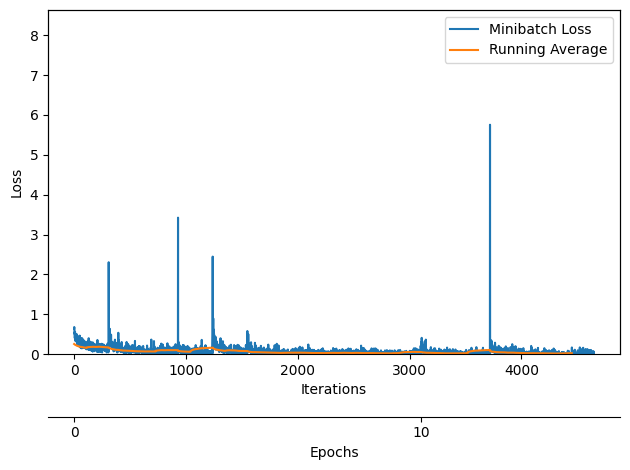

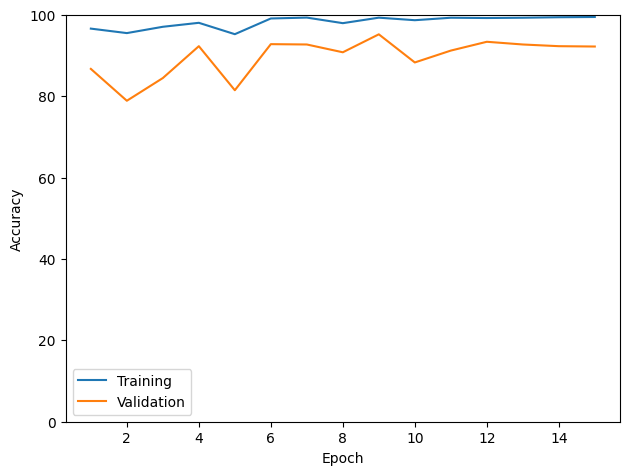

In [17]:
minibatch_loss_list, train_acc_list, valid_acc_list = training.train_model(
    model=model,

    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,

    valid_loader=validation_loader,
    test_loader=test_loader,

    optimizer=optimizer,

    device=DEVICE,

    logging_interval=100,
    model_name="effnet_b0_pretrained")


plotting.plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)

plt.show()


plotting.plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)

plt.ylim([0, 100])

plt.show()

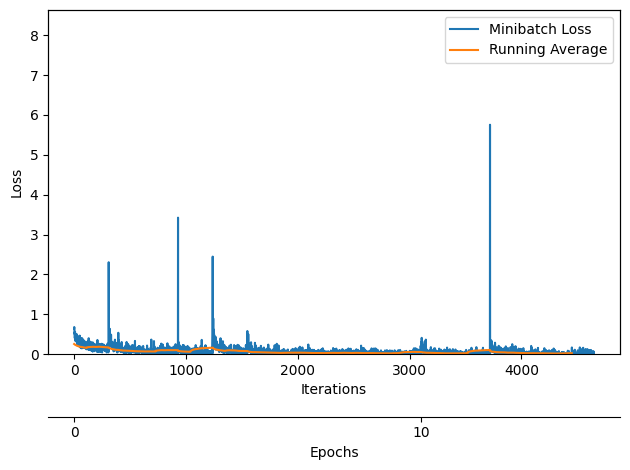

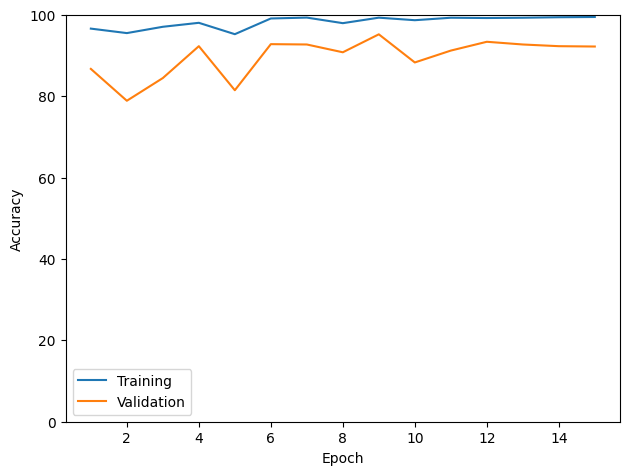

In [18]:
plotting.plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                            num_epochs=NUM_EPOCHS,
                            iter_per_epoch=len(train_loader),
                            results_dir=None,
                            averaging_iterations=200)
plt.savefig("./plots/effnet_b0_pretrained-train-loss.png")
plt.show()


plotting.plot_accuracy(train_acc_list=train_acc_list,   
                       valid_acc_list=valid_acc_list,
                       results_dir=None)

plt.ylim([0, 100])
plt.savefig("./plots/effnet_b0_pretrained_accuracy.png", dpi=300)
plt.show()

In [19]:
confusion_matrix = evaluation.compute_confusion_matrix(model, test_loader, device=DEVICE)

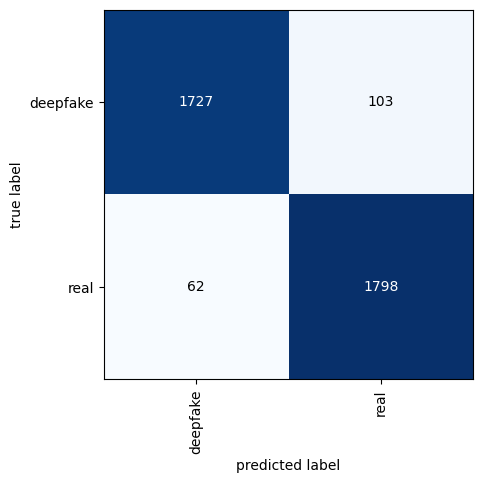

In [20]:
fig, _ = plotting.plot_confusion_matrix(confusion_matrix, class_names=['deepfake', 'real'])

plt.savefig("./plots/effnet_b0_pretrained-confusion-matrix.png", dpi=300)

In [ ]:
torch.save(model, 'baseline.pth')